In [1]:
import os
import json
import torch
import random
import cv2
import math
import numpy as np
import torchvision
from pathlib import Path
from torch import nn
from torch import optim
import torch.utils.data as Data
from torch.utils.data import Dataset
from torch.nn import functional as F
from torchvision import models, transforms
import matplotlib.pyplot as plt 
import matplotlib
import tqdm
from PIL import Image
from module import *
from model import *
from dataset import *
from metric import *

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tau = 3

In [2]:
YTB_dataset = YouTubeVOS_Data()
train_size = int(0.8 * len(YTB_dataset))
valid_size = len(YTB_dataset) - train_size
train_dataset, valid_dataset = Data.random_split(YTB_dataset, [train_size, valid_size])
train_dataloader = Data.DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_dataloader = Data.DataLoader(valid_dataset, batch_size=1, shuffle=True)
print(len(train_dataloader), len(valid_dataloader))

2776 695


Data shape: torch.Size([1, 36, 3, 256, 448])
Mask shape: torch.Size([1, 36, 720, 1280])
Pred shape: torch.Size([1, 36, 256, 448])
Num of Objects: 2


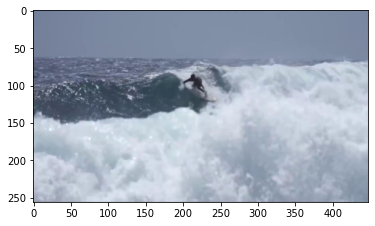

In [3]:
datapack = next(iter(train_dataloader))
a = datapack['Frames']
b = datapack['Masks']
b0 = datapack['Preds']
c = datapack['Num_objs']
print(f"Data shape: {a.shape}")
print(f"Mask shape: {b.shape}")
print(f"Pred shape: {b0.shape}")
print(f"Num of Objects: {int(c)}")
img = a[0][0].permute(1,2,0)
plt.imshow(img)

In [4]:
msk0 = b.transpose(0,1)
resiz = F.interpolate(msk0, size=[256,448], mode='nearest')
resiz.shape

torch.Size([19, 1, 256, 448])

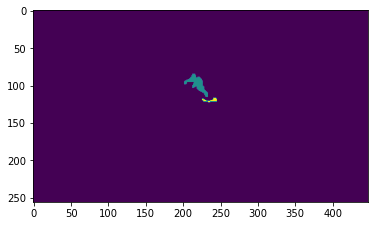

In [5]:
plt.imshow(b0[0][0])

In [6]:
CNN = CNNBackbone()
CNN = CNN.to(device)

PE = PositionalEncoding3D()
PE = PE.to(device)

x, m = a.to(device), b0.to(device)

In [ ]:
cnnout = CNN(x)
pef = PE(cnnout)
emb = cnnout + pef

In [ ]:
b0.unique()

In [ ]:
SA = SparseAttention()
SA = SA.to(device)

attout, objaf = SA(emb, m, int(c)+1)
attout.shape, objaf.shape

In [ ]:
print(f"Data shape: {a.shape}")
print(f"Mask shape: {b.shape}")
print(f"Pred shape: {b0.shape}")

In [ ]:
ENC = SSTEncoder()
ENC = ENC.to(device)
affout, objaf = ENC(emb, m, int(c)+1)
attout.shape, objaf.shape, cnnout.shape

In [ ]:
_, T, _, H, W = a.shape
tau = 4
for idx in range(T):
    if idx < tau:
        frame_tau = a[:,0:idx+1,:,:,:]
    else:
        frame_tau = a[:,idx+1-tau:idx+1,:,:,:]
    print(frame_tau.shape)

In [ ]:
cnn_fs = CNN(x)
cnn_feat = cnn_fs
pe = PE(cnn_fs)
y = pe + cnn_fs


cnn_fs.shape, y.shape

In [ ]:
DEC = DecoderBlock(512*2+1,512,1)
DEC = DEC.to(device)
sigmoid = nn.Sigmoid()

In [ ]:
b[0][0].shape

In [ ]:
self_attn1 = SSTEncoder().cuda()
self_attn2 = SSTEncoder().cuda()
self_attn3 = SSTEncoder().cuda()
self_attn4 = SSTEncoder().cuda()
dec1 = DecoderBlock(512*2+4*1,1024,512).cuda()
dec2 = DecoderBlock(512,256,256).cuda()
dec3 = DecoderBlock(256,128,1).cuda()


In [ ]:
torch.cuda.empty_cache()

In [3]:
tau = 5
sigmoid = nn.Sigmoid()
num_cls = int(c)+1
# y = y.cuda()
# m = m.cuda()
outputs = []
for idx in range(1,4):
    if idx < tau:
        emb_tau = y[:,0:idx+1,:,:,:]                   # Slice the embed feat
        msk_tau = m[:,0:idx+1,:,:]                              # Slice the pred mask
    else:
        emb_tau = cnn_fs[:,idx+1-tau:idx+1,:,:,:]
        msk_tau = m[:,idx+1-tau:idx+1,:,:]
    trans_tau, objaff_tau1 = self_attn1(emb_tau, msk_tau, num_cls)
    trans_tau, objaff_tau2 = self_attn2(trans_tau, msk_tau, num_cls)
    trans_tau, objaff_tau3 = self_attn3(trans_tau, msk_tau, num_cls)
    trans_tau, objaff_tau4 = self_attn4(trans_tau, msk_tau, num_cls)

    objprob_list = []
    for obj_id in range(0,num_cls):
        objaff_tau1_each = objaff_tau1[:,:,obj_id,:,:].unsqueeze(2)
        objaff_tau2_each = objaff_tau2[:,:,obj_id,:,:].unsqueeze(2)
        objaff_tau3_each = objaff_tau3[:,:,obj_id,:,:].unsqueeze(2)
        objaff_tau4_each = objaff_tau4[:,:,obj_id,:,:].unsqueeze(2)
        all_feat = torch.cat([trans_tau,emb_tau,
                            objaff_tau1_each,objaff_tau2_each,
                            objaff_tau3_each,objaff_tau4_each],dim=2)
        z = dec1(all_feat.float())
        z = dec2(z)
        z = dec3(z)
        obj_prob = sigmoid(z[-1])
        objprob_list.append(obj_prob)
    obj_prob = torch.cat(objprob_list,0)
    obj_pred = torch.argmax(obj_prob,0)
    # m[0][idx] = obj_pred
    outputs.append(obj_prob)

NameError: name 'c' is not defined

In [ ]:
outputs[0].shape

In [ ]:
obj_pred.shape

In [ ]:
obj_prob[0].shape

In [ ]:
prob_output = []
# prob_output.append(b[0][0])
for idx in range(1,T):
    if idx < tau:
        emb_tau = cnn_fs[:,0:idx+1,:,:,:]
        msk_tau = m[:,0:idx+1,:,:]
    else:
        emb_tau = cnn_fs[:,idx+1-tau:idx+1,:,:,:]
        msk_tau = m[:,idx+1-tau:idx+1,:,:]
    # print(emb_tau.shape, msk_tau.shape)
    enc_tau, objaff_tau = ENC(emb_tau, msk_tau, c+1)

    
    obj_prob = []
    for obj_id in range(1,c+1):
        objaff_tau_id = objaff_tau[:,:,obj_id,:,:].unsqueeze(2)
        print(objaff_tau_id.shape)
        dec_in = torch.cat([emb_tau,enc_tau,objaff_tau_id],dim=2).float()
        dec_out = DEC(dec_in)
        # dec_out = F.interpolate(dec_out[0],size=[720,1280],mode='bilinear',align_corners=True)
        obj_idx = sigmoid(dec_out[0][-1])  # Apply sigmoid to predict prob of each object
        obj_prob.append(obj_idx)
        # print(obj_idx.shape)
    obj_prob = torch.cat(obj_prob,0)    # Cat together all objects
    prob_output.append(obj_prob)
    obj_pred = torch.argmax(obj_prob, 0)    # Get pred mask in 1 channel
    m[0,idx,:,:] = obj_pred
    # print(obj_pred.shape)
        # print(enc_tau.shape, objaff_tau.shape)
output = torch.stack(prob_output,0)
output.shape

In [29]:
def jaccard(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    res = (intersection + 1e-15) / (union + 1e-15)
    return res.detach().cpu().numpy()


def dice(y_true, y_pred):
    res = (2 * (y_true * y_pred).sum() + 1e-15) / (y_true.sum() + y_pred.sum() + 1e-15)
    return res.detach().cpu().numpy()

def get_Dice(y_true, y_pred):
    result = []

    if y_true.sum() == 0:
        if y_pred.sum() == 0:
            return 1
        else:
            return 0
            
    classes = y_true.unique().detach().cpu().tolist()
    for instrument_id in classes:
        if instrument_id == 0:
            continue
        result.append(dice(y_true == instrument_id, y_pred == instrument_id))

    return np.mean(result)

def get_Jaccard(y_true, y_pred):
    result = []

    if y_true.sum() == 0:
        if y_pred.sum() == 0:
            return 1
        else:
            return 0

    classes = y_true.unique().detach().cpu().tolist()
    for instrument_id in classes:
        if instrument_id == 0:
            continue
        result.append(jaccard(y_true == instrument_id, y_pred == instrument_id))

    return np.mean(result)

### Training

In [4]:
criterion = nn.CrossEntropyLoss()
model = MyTransformer()
model = model.to(device)
tau = 5

In [4]:
datapack = next(iter(train_dataloader))
data, mask, temp, num_objs = datapack['Frames'].to(device), datapack['Masks'].to(device), datapack['Preds'].to(device), int(datapack['Num_objs'])
data.shape, mask.shape, temp.shape, num_objs

(torch.Size([1, 19, 3, 256, 448]),
 torch.Size([1, 19, 360, 480]),
 torch.Size([1, 19, 256, 448]),
 1)

In [8]:
datapack = next(iter(train_dataloader))
data, mask, temp, num_objs = datapack['Frames'].to(device), datapack['Masks'].to(device), datapack['Preds'].to(device), int(datapack['Num_objs'])
print(data.shape, mask.shape, temp.shape, num_objs)
_, T, _, _, _ = data.shape
_, _, H, W = mask.shape
num_cls = num_objs + 1
for frame_idx in range(1,T):
    if frame_idx < tau:
        x = data[:,0:frame_idx+1,:,:,:]
        m = temp[:,0:frame_idx+1,:,:]
        # gt = mask[:,0:frame_idx+1,:,:]
        gt = mask[:,frame_idx,:,:].long()
    else: 
        x = data[:,frame_idx+1-tau:frame_idx+1,:,:,:]
        m = temp[:,frame_idx+1-tau:frame_idx+1,:,:]
        # gt = mask[:,frame_idx+1-tau:frame_idx+1,:,:]
        gt = mask[:,frame_idx,:,:].long()
    output, preds = model(x, m, num_cls)
    output = F.interpolate(output[:,-1,:,:,:],size=[H,W],mode='bilinear',align_corners=True)
    preds = preds[:,-1,:,:]
    temp[0][frame_idx] = preds                                  # Update prediction to temp
    loss = criterion(output, gt)
    # loss.backward()                                 # Compute gradients
    # optimizer.step()                                # Update the model parameters
    # optimizer.zero_grad()
    preds = F.interpolate(preds.float().unsqueeze(0),size=[H,W],mode='nearest').squeeze(0)
    jaccard = get_Jaccard(gt, preds)
    dice = get_Dice(gt, preds)
    print(jaccard, dice)

torch.Size([1, 36, 3, 256, 448]) torch.Size([1, 36, 720, 1280]) torch.Size([1, 36, 256, 448]) 1
0.18583578 0.31342584
0.1698541 0.2903851
0.14231867 0.24917507
0.15830907 0.27334514
0.13814764 0.24275872
0.14736456 0.25687486
0.15014885 0.26109466
0.15105714 0.26246682
0.15070139 0.26192963
0.121152036 0.21612062
0.13575381 0.239055
0.1409003 0.24699844
0.17302108 0.2950008
0.15863445 0.27383003
0.1639503 0.28171358
0.17308466 0.2950932
0.16255702 0.2796543
0.1580157 0.2729077
0.13354856 0.23562917
0.11674641 0.20908312
0.11785122 0.21085314
0.10315919 0.18702503
0.09016708 0.16541883
0.094879724 0.17331533
0.08448208 0.15580171
0.06539247 0.122757524
0.057528187 0.10879745
0.061693754 0.11621761
0.05833086 0.1102318
0.050780773 0.09665341
0.04323779 0.08289153
0.042380102 0.08131411
0.03368372 0.0651722
0.027403865 0.053345848
0.014671029 0.028917802


In [25]:
newtensor = torch.Tensor(10)
newtensor.cuda()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

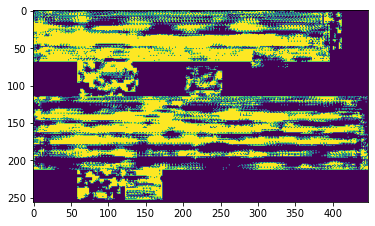

In [11]:
plt.imshow(temp[0][2].detach().cpu())

In [90]:
loss = criterion(output, gt)
loss.backward()                                 # Compute gradients
optimizer.step()                                # Update the model parameters
optimizer.zero_grad()

tensor(1.3863, device='cuda:0', grad_fn=<NllLoss2DBackward>)

In [36]:
preds = F.interpolate(preds.float().unsqueeze(0),size=[720,1280],mode='nearest').squeeze(0)
get_Jaccard(gt, preds)

1.5580188e-18

In [7]:
class MyTransformer(nn.Module):
    def __init__(self, num_layers=4):
        super(MyTransformer, self).__init__()

        self.backbone = CNNBackbone()
        self.pos_encoding = PositionalEncoding3D()
        self.self_attn1 = SSTEncoder()
        self.self_attn2 = SSTEncoder()
        self.self_attn3 = SSTEncoder()
        self.self_attn4 = SSTEncoder()
        # self.self_attn5 = SSTEncoder()
        # input dim = CNN_out * 2 + num_layers * N_classes
        self.dec1 = DecoderBlock(512*2+4*1,1024,512)
        self.dec2 = DecoderBlock(512,256,256)
        self.dec3 = DecoderBlock(256,128,1)
        # self.conv1 = Upscaler1x1Conv(512*2+5*5,512,2)
        # self.conv2 = Upscaler1x1Conv(512*2+5*5,256,4)
        # self.dec4 = DecoderBlock(128,64,8)
        self.sigmoid = nn.Sigmoid()
        self.cnn_feat = torch.zeros(1)
        self.encod_feat = torch.zeros(1)
        self.attn_scores = torch.zeros(1)
        self.object_affinity = torch.zeros(1)
        self.tau = 4
        self.sigmoid = nn.Sigmoid()
    

    def forward(self, x, m, num_cls):
        """
        x - input frames sequence;
        m - previous masks prediction;
        c - num of objects
        """
        _, T, _, H, W = x.shape
        # 1. subtract feature embedding from CNN backbone [b,T,C,H',W']
        cnn_feats = self.backbone(x)
        self.cnn_feat = cnn_feats
        # Get positional encoding and add it to the feature embedding
        pe = self.pos_encoding(cnn_feats)
        emb_feat = pe + cnn_feats
 
        # 2. Encoded feature from transformer layers 

        trans_feat, objaff_1 = self.self_attn1(emb_feat, m, num_cls)
        trans_feat, objaff_2 = self.self_attn2(trans_feat, m, num_cls)
        trans_feat, objaff_3 = self.self_attn3(trans_feat, m, num_cls)
        trans_feat, objaff_4 = self.self_attn4(trans_feat, m, num_cls)
        
        obj_prob_list = []
        for obj_id in range(0, num_cls):
            objaff_1_each = objaff_1[:,:,obj_id,:,:].unsqueeze(2)
            objaff_2_each = objaff_2[:,:,obj_id,:,:].unsqueeze(2)
            objaff_3_each = objaff_3[:,:,obj_id,:,:].unsqueeze(2)
            objaff_4_each = objaff_4[:,:,obj_id,:,:].unsqueeze(2)
            all_feat = torch.cat([trans_feat,cnn_feats,objaff_1_each,objaff_2_each,objaff_3_each,objaff_4_each],dim=2).float()
            z = self.dec1(all_feat)
            z = self.dec2(z)
            z = self.dec3(z)
            z = self.sigmoid(z)
            obj_prob_list.append(z)
            print("zzzzz", z.shape)
        output = torch.cat(obj_prob_list, 2)        # Concatnate on channel (object cls) dim
        preds = torch.argmax(output,2)           # Argmax on channel dim
        out = F.interpolate(output[:,-1,:,:,:],size=[720,1280],mode='bilinear',align_corners=True)
        return out, preds[:,-1,:,:]
        # obj_prob_list = []
        # for obj_id in range(0,num_cls):
        #     objaff_tau1_each = objaff_tau1[:,:,obj_id,:,:].unsqueeze(2)
        #     objaff_tau2_each = objaff_tau2[:,:,obj_id,:,:].unsqueeze(2)
        #     objaff_tau3_each = objaff_tau3[:,:,obj_id,:,:].unsqueeze(2)
        #     objaff_tau4_each = objaff_tau4[:,:,obj_id,:,:].unsqueeze(2)
        #     all_feat = torch.cat([trans_tau,emb_tau,objaff_tau1_each,objaff_tau2_each,objaff_tau3_each,objaff_tau4_each],dim=2).float()
        #     z = self.dec1(all_feat)
        #     z = self.dec2(z)
        #     z = self.dec3(z)
        #     obj_prob.append(z[-1])
        #     obj_prob = self.sigmoid(obj_prob)
        #     obj_prob_list.append(obj_prob)
        # obj_prob = torch.cat(obj_prob_list,0)
        # obj_pred = torch.argmax(obj_prob,0)
        # print(emb_feat.shape, objaff_tau4.shape)
        # return trans_tau, objaff_tau4

model = MyTransformer().cuda()

In [ ]:
c

In [ ]:
m.unique()

In [ ]:
model(x, m, num_cls)


In [6]:
def train(model, train_dataloader, valid_dataloader, criterion, optimizer, epochs):
    
    LOSS_train = []
    LOSS_valid = []
    Jaccard_train = []
    Jaccard_valid = []  
    Dice_train = []
    Dice_valid = []

    for epoch in tqdm.trange(epochs, desc="Epochs"):
        result = [] 
                loss.backward()                                 # Compute gradients
                optimizer.step()                                # Update the model parameters
                optimizer.zero_grad()
                preds = F.interpolate(preds.float().unsqueeze(0),size=[H,W],mode='nearest').squeeze(0)
                train_loss += loss.item()        # Compute training loss
                train_Jaccard += get_Jaccard(gt, preds)
                train_dice += get_Dice(gt, preds)


        # Begin validation
        model.eval()
        for datapack in valid_dataloader:
            data, mask, temp, num_objs = datapack['Frames'].to(device), datapack['Masks'].to(device), datapack['Preds'].to(device), int(datapack['Num_objs'])
            T = data.shape[1]
            _, _, H, W = mask.shape
            for frame_idx in range(1, T):
                if frame_idx < tau:
                    x = data[:,0:frame_idx+1,:,:,:]
                    m = temp[:,0:frame_idx+1,:,:]
                    # gt = mask[:,0:frame_idx+1,:,:]
                    gt = mask[:,frame_idx,:,:].long()
                else:
                    x = data[:,frame_idx+1-tau:frame_idx+1,:,:,:]
                    m = temp[:,frame_idx+1-tau:frame_idx+1,:,:]
                    # gt = mask[:,frame_idx+1-tau:frame_idx+1,:,:]
                    gt = mask[:,frame_idx,:,:].long()
                output, preds = model(x, m, num_cls)
                output = F.interpolate(output[:,-1,:,:,:],size=[H,W],mode='bilinear',align_corners=True)
                preds = preds[:,-1,:,:]
                temp[0][frame_idx] = preds                                  # Update prediction to temp
                loss = criterion(output, gt)
                preds = F.interpolate(preds.float().unsqueeze(0),size=[H,W],mode='nearest').squeeze(0)
                train_loss += loss.item()      # Compute training loss
                train_Jaccard += get_Jaccard(gt, preds)
                train_dice += get_Dice(gt, preds)
                
        # Compute epoch loss and f1
        epoch_train_loss = train_loss / len(train_dataloader.dataset)
        epoch_train_Jaccard = train_Jaccard / len(train_dataloader.dataset)
        epoch_train_dice = train_dice / len(train_dataloader.dataset)
        epoch_valid_loss = valid_loss / len(valid_dataloader.dataset)
        epoch_valid_Jaccard = valid_Jaccard / len(valid_dataloader.dataset)
        epoch_valid_dice = valid_dice / len(valid_dataloader.dataset)

        # Record epoch loss and f1 to the list
        LOSS_train.append(epoch_train_loss)
        LOSS_valid.append(epoch_valid_loss)
        Jaccard_train.append(epoch_train_Jaccard)
        Jaccard_valid.append(epoch_valid_Jaccard)   
        Dice_train.append(epoch_train_dice)
        Dice_valid.append(epoch_valid_dice)

        result.append(f'{epoch} TRAIN loss: {epoch_train_loss:.4f}, Jaccard: {epoch_train_Jaccard:.4f}, Dice: {epoch_train_dice:.4f};  VALID loss: {epoch_valid_loss:.4f}, Jaccard: {epoch_valid_Jaccard:.4f}, Dice: {epoch_valid_dice:.4f}')

        print(result)
    return LOSS_train, LOSS_valid, Jaccard_train, Jaccard_valid, Dice_train, Dice_valid

In [7]:
model = MyTransformer()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(), lr=0.01)
LOSS_train, LOSS_valid, Jaccard_train, Jaccard_valid, Dice_train, Dice_valid = train(model, train_dataloader, valid_dataloader, criterion, optimizer, epochs=1)

Epochs:   0%|          | 0/1 [4:11:43<?, ?it/s]


RuntimeError: Class values must be smaller than num_classes.

In [ ]:
torch.save(model,"C:/Users/Siyao/Downloads/YOUTUBE-VOS/models/1115_ytb.pt")